In [26]:
import pandas as pd
import sys
import pyspark.sql
from pyspark.sql.types import StructType, StructField, DateType, StringType, DoubleType, TimestampType
from SparkDBUtils import SparkDB
import datetime
from pyspark.sql.functions import current_timestamp

sparkdb = SparkDB()
spark = sparkdb.spark

In [18]:
producto_dim_schema = StructType([
        StructField("date", DateType(), True),
        StructField("product", StringType(), True),
        StructField("product_id", StringType(), True),
        StructField("brand", StringType(), True),
        StructField("price", DoubleType(), True),
        StructField("categories", StringType(), True),
        StructField("unit_price", DoubleType(), True),
        StructField("units", StringType(), True),
        StructField("discount", DoubleType(), True),
        StructField("ts_load", TimestampType(), True)
    ])

dataset = spark.read.option("delimiter", ";").csv("../../dataset/dataset.csv",  schema= producto_dim_schema, header=True)

In [19]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=None)

In [27]:
dataset = dataset.withColumn("ts_load", current_timestamp())

In [29]:
dataset.summary().show()

+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|summary|             product|        product_id|         brand|             price|          categories|        unit_price|          units|discount|
+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|  count|              258598|            258598|        251175|            258171|              258598|            258171|         258171|       0|
|   mean|                null|184070.27116739505|          null| 3.335872270704507|                null|13.251186732823822|           null|    null|
| stddev|                null| 93759.95093658975|          null|4.6163258336936766|                null| 59.14028297290332|           null|    null|
|    min|1902 licor de gin...|               100|ABADIA DA COVA|              0.15|['Aceites. salsas...|  

In [28]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=datetime.datetime(2023, 9, 15, 6, 53, 39, 969000))

In [30]:
sparkdb.write_table(dataset, "producto_dia.producto_dim", "append")

# Analisis de la migración

In [31]:
df_producto_dim = spark.table("producto_dia.producto_dim")

In [33]:
df_producto_dim.summary().show()

+-------+-----------------+--------------------+--------------+--------------------+---------------+-----------------+------------------+--------+
|summary|       product_id|             product|         brand|          categories|          units|            price|        unit_price|discount|
+-------+-----------------+--------------------+--------------+--------------------+---------------+-----------------+------------------+--------+
|  count|           283964|              281643|        274220|              283964|         282134|           282134|            282134|       0|
|   mean|184860.8042095201|                null|          null|                null|           null|3.354801406421586|13.322132249216615|    null|
| stddev|93761.80664985458|                null|          null|                null|           null|4.682288481983296| 77.87560232183472|    null|
|    min|              100|1902 licor de gin...|ABADIA DA COVA|['Aceites. salsas...|     €/100 GR.)|             0.15|

In [34]:
df = df_producto_dim.toPandas()

c:\users\carlos\proyectos\foodecommercescraper\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283964 entries, 0 to 283963
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   product_id  283964 non-null  object        
 1   product     281643 non-null  object        
 2   brand       274220 non-null  object        
 3   categories  283964 non-null  object        
 4   units       282134 non-null  object        
 5   price       282134 non-null  float64       
 6   unit_price  282134 non-null  float64       
 7   discount    0 non-null       float64       
 8   date        283964 non-null  object        
 9   ts_load     283964 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 21.7+ MB


In [42]:
df["date"]  = pd.to_datetime(df["date"])

<AxesSubplot: xlabel='date,date'>

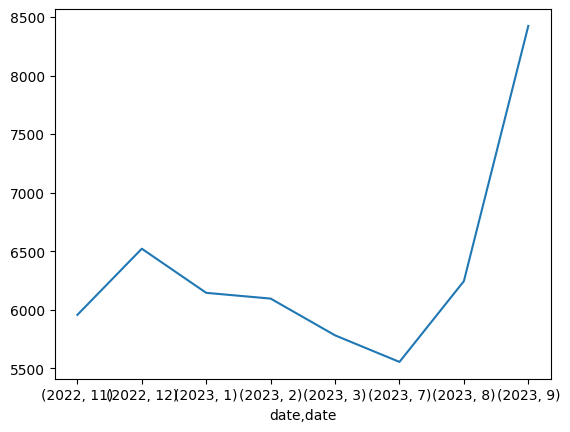

In [55]:
df.groupby([df.date.dt.year,df.date.dt.month])["product_id"].agg(pd.Series.nunique).plot(kind="line")